## Imports

In [134]:
import time
import numpy as np
import cv2
from skimage.feature import hog

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import svm, datasets
from scipy.ndimage.measurements import label

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import glob
import random

%matplotlib inline

## Constants

In [101]:
PATH_TEST_IMAGES = 'test_images/'
PATH_VEHICLE_IMAGES = 'train_test_data/vehicles/'
PATH_NON_VEHICLE_IMAGES = 'train_test_data/non-vehicles/'

YSTART = 400
YSTOP = 656

# SPATIAL_BIN = 16
# HIST_BINS= 64
# ORIENT = 6
# PIX_PER_CELLS = 8
# CELL_PER_BLOCK = 2
# SCALE = 1.5

SPATIAL_BIN = 16
HIST_BINS= 64
ORIENT = 6
PIX_PER_CELLS = 8
CELL_PER_BLOCK = 2
SCALE = 1.5

## 1. Histogram of Oriented Gradients (HOG)

In [76]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [77]:
# # Define a function to extract features from a list of images
# # Have this function call bin_spatial() and color_hist()
# def extract_features_THOMAS(imgs, cspace, spatial_size, 
#                         hist_bins,orient, pix_per_cell, cell_per_block):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if cspace != 'RGB':
#             if cspace == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif cspace == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif cspace == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif cspace == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif cspace == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      
#         # Apply bin_spatial() to get spatial color features
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         # Apply color_hist() also with a color space option now
#         hist_features = color_hist(feature_image, nbins=hist_bins)
        
#         #HOG
#         ch1 = feature_image[:,:,0]
#         ch2 = feature_image[:,:,1]
#         ch3 = feature_image[:,:,2]

#         # Compute individual channel HOG features for the entire image
#         hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#         hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
        
#         hog_feat1 = hog1.ravel() 
#         hog_feat2 = hog2.ravel() 
#         hog_feat3 = hog3.ravel() 
#         hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#         # Scale features and make a prediction
#         #features = np.hstack((spatial_features, hist_features, hog_features)) 

#         # Append the new feature vector to the features list
#         features.append(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
        
        
#     # Return list of feature vectors
#     return features

In [78]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [79]:
# def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):
#     # Create a list to append feature vectors to
#     features = []
#     # Iterate through the list of images
#     for file in imgs:
#         file_features = []
#         # Read in each one by one
#         image = mpimg.imread(file)
#         # apply color conversion if other than 'RGB'
#         if color_space != 'RGB':
#             if color_space == 'HSV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#             elif color_space == 'LUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
#             elif color_space == 'HLS':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
#             elif color_space == 'YUV':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
#             elif color_space == 'YCrCb':
#                 feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
#         else: feature_image = np.copy(image)      

#         if spatial_feat == True:
#             spatial_features = bin_spatial(feature_image, size=spatial_size)
#             file_features.append(spatial_features)
#         if hist_feat == True:
#             # Apply color_hist()
#             hist_features = color_hist(feature_image, nbins=hist_bins)
#             file_features.append(hist_features)
#         if hog_feat == True:
#         # Call get_hog_features() with vis=False, feature_vec=True
#             if hog_channel == 'ALL':
#                 hog_features = []
#                 for channel in range(feature_image.shape[2]):
#                     hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=False))
#                 hog_features = np.ravel(hog_features)        
#             else:
#                 hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=False)
#             # Append the new feature vector to the features list
#             file_features.append(hog_features)
#         features.append(np.concatenate(file_features))
#     # Return list of feature vectors
#     return features

In [80]:
# #Original Title single_img_features
# def extract_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)

In [127]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hot_windows):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255

#     print("find_cars: img")
#     print(img[:20])
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)))
            find_Before_Scaler = np.hstack((spatial_features, hist_features, hog_features))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw+ystart)
                down_right = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img, top_left , down_right, (0,0,255),6) 
                
                # Assuming each "box" takes the form ((x1, y1), (x2, y2))
                hot_windows.append((top_left, down_right))

    return draw_img, hot_windows

In [82]:
# # Define a single function that can extract features using hog sub-sampling and make predictions
# def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
#     draw_img = np.copy(img)
#     img = img.astype(np.float32)/255
    
#     img_tosearch = img[ystart:ystop,:,:]
#     ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
#     if scale != 1:
#         imshape = ctrans_tosearch.shape
#         ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
#     ch1 = ctrans_tosearch[:,:,0]
#     ch2 = ctrans_tosearch[:,:,1]
#     ch3 = ctrans_tosearch[:,:,2]

#     # Define blocks and steps as above
#     nxblocks = (ch1.shape[1] // pix_per_cell)-1
#     nyblocks = (ch1.shape[0] // pix_per_cell)-1 
#     nfeat_per_block = orient*cell_per_block**2
#     # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
#     window = 64
#     nblocks_per_window = (window // pix_per_cell)-1 
#     cells_per_step = 2  # Instead of overlap, define how many cells to step
#     nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
#     nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
#     # Compute individual channel HOG features for the entire image
#     hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
#     for xb in range(nxsteps):
#         for yb in range(nysteps):
#             ypos = yb*cells_per_step
#             xpos = xb*cells_per_step
#             # Extract HOG for this patch
#             hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
#             hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
#             hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window]
#             hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

#             xleft = xpos*pix_per_cell
#             ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)))
#             #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
#             test_prediction = svc.predict(test_features)
            
#             if test_prediction == 1:
#                 xbox_left = np.int(xleft*scale)
#                 ytop_draw = np.int(ytop*scale)
#                 win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
#     return draw_img

In [83]:
def read_image(filename):
    image = mpimg.imread(PATH_TEST_IMAGES+filename)
    return image
    
def crop_vertical(image):
    #vertical_center = (int)(image.shape[0]/2)
    return image[YSTART:YSTOP]

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def init_image(filename):
    #Read image
    image = read_image(filename)
    #Crop the vertical upper half. Cars can only be in the lower half of the image
    image = crop_vertical(image)
    #Convert to grayscale
    image = grayscale(image)
    
    return image

## HOG - Tests

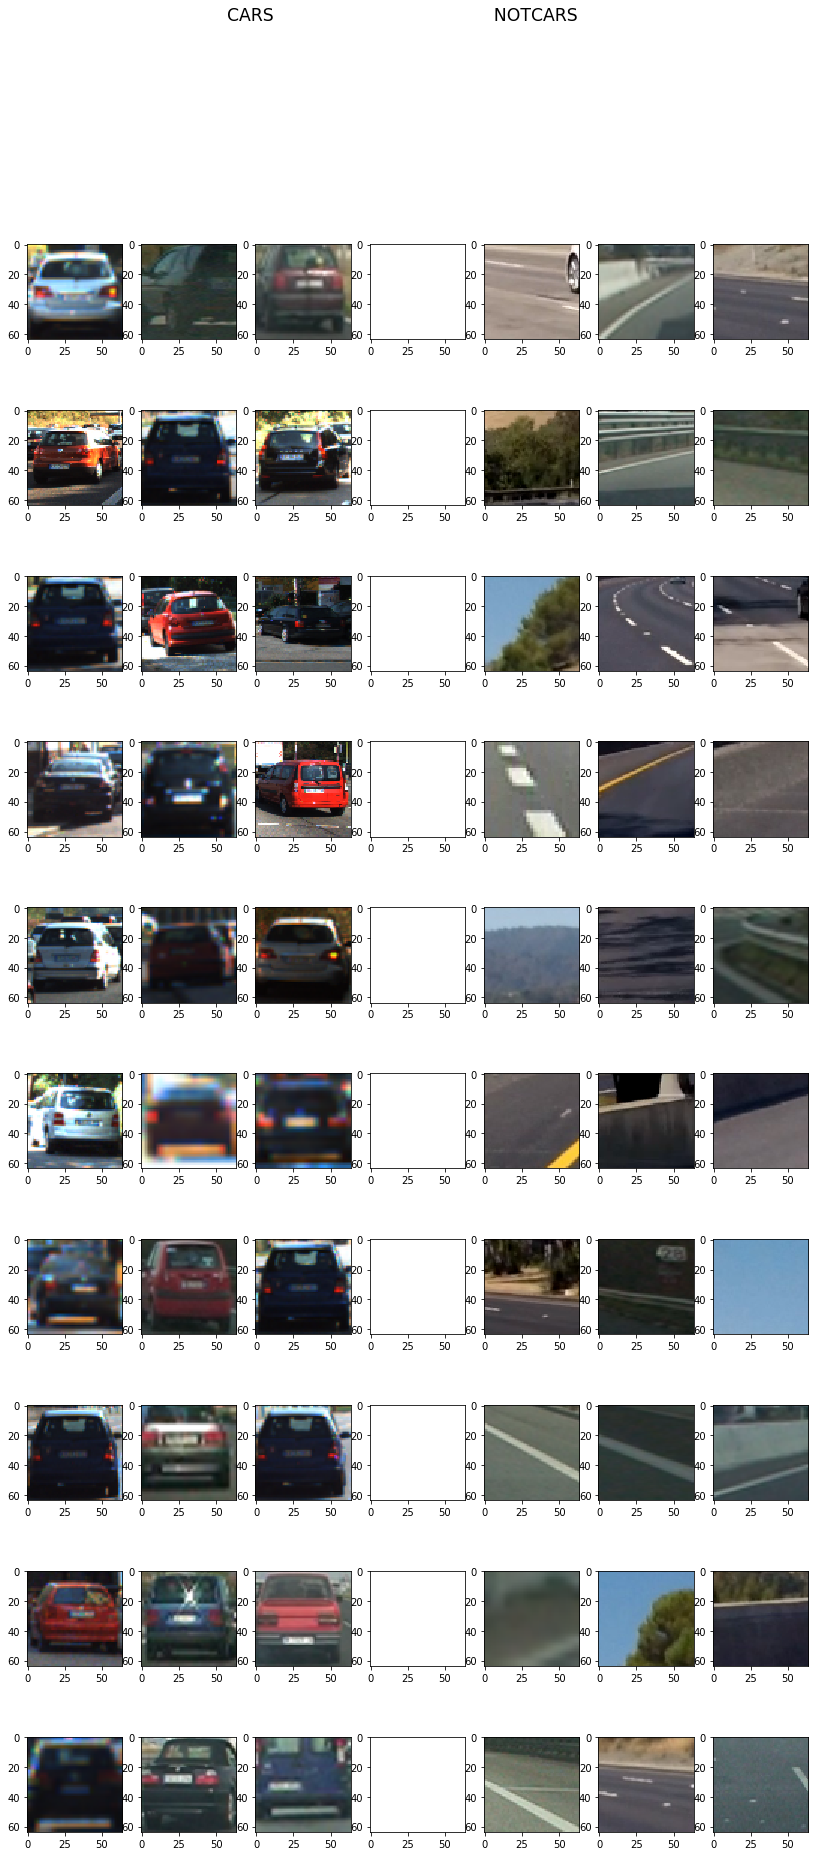

In [84]:
cars = []
images = glob.glob(PATH_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    cars.append(image)

notcars = []    
images = glob.glob(PATH_NON_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    notcars.append(image)
    
f, ax = plt.subplots(10, 7, figsize=(14,30))
cars_indicies = random.sample(range(0, len(cars)), 30)
notcars_indicies = random.sample(range(0, len(notcars)), 30)
blank = np.ones_like(mpimg.imread(cars[0]))

f.suptitle('CARS                                        NOTCARS ', fontsize='xx-large')

for i in range(3):
    for j in range(10):
        example_car = mpimg.imread(cars[cars_indicies[10*i+j]])
        example_notcar = mpimg.imread(notcars[notcars_indicies[10*i+j]])
        
        ax[j][i].imshow(example_car)
        ax[j][i+4].imshow(example_notcar)
        ax[j][3].imshow(blank)

Number of Car-Images: 8792
Number of Non-Car-Images: 8968


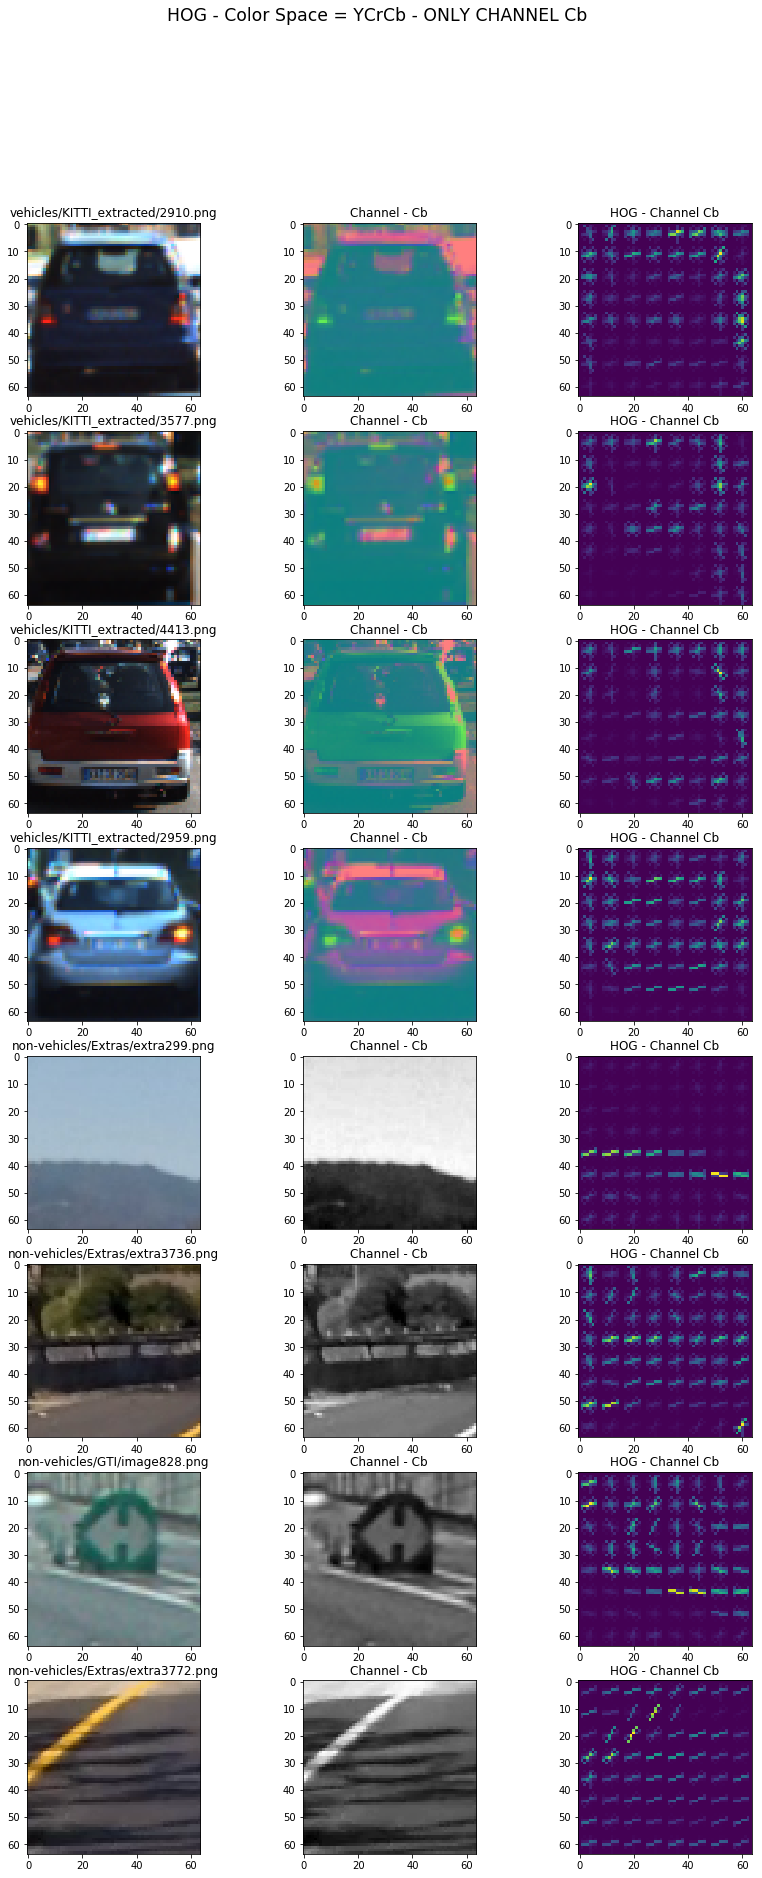

In [85]:
cars = []
images = glob.glob(PATH_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    cars.append(image)

notcars = []    
images = glob.glob(PATH_NON_VEHICLE_IMAGES+'/*/*.png')
for image in images:
    notcars.append(image)

print("Number of Car-Images: {}".format(len(cars)))
print("Number of Non-Car-Images: {}".format(len(notcars)))
#car_features = extract_features(cars, cspace, (spatial_size, spatial_size), hist_bins, 
#                                orient, pix_per_cell, cell_per_block)
EXAMPLE_SIZE = 4
f, ax = plt.subplots(2*EXAMPLE_SIZE, 3, figsize=(14,30))

#cars_indicies = random.sample(range(0, len(cars)), EXAMPLE_SIZE)
cars_indicies = [2429, 4805, 5786, 4970]
CHANNEL = 2
CHANNEL_NAME = 'Cb'
f.suptitle('HOG - Color Space = YCrCb - ONLY CHANNEL ' + CHANNEL_NAME , fontsize='xx-large')
for i, index in enumerate(cars_indicies):
    example_car = mpimg.imread(cars[index])
    gray_example_car = cv2.cvtColor(example_car, cv2.COLOR_RGB2YCrCb)
    _, hog_example_car = get_hog_features(gray_example_car[:,:,CHANNEL], ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK, vis=True, feature_vec=True)

    ax[i][0].imshow(example_car)
    ax[i][0].set_title(cars[index][16:])
    
    ax[i][1].imshow(gray_example_car, cmap='gray')
    ax[i][1].set_title("Channel - " + CHANNEL_NAME)
    
    ax[i][2].imshow(hog_example_car)
    ax[i][2].set_title("HOG - Channel " + CHANNEL_NAME )

#notcars_indicies = random.sample(range(0, len(notcars)), EXAMPLE_SIZE)
notcars_indicies = [5705, 3910, 1802, 8544]
for i, index in enumerate(notcars_indicies):    
    example_notcar = mpimg.imread(notcars[index])
    gray_example_notcar = grayscale(example_notcar)
    _, hog_example_notcar = get_hog_features(gray_example_notcar, ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK, vis=True, feature_vec=True)

    ax[i+EXAMPLE_SIZE][0].imshow(example_notcar)
    ax[i+EXAMPLE_SIZE][0].set_title(notcars[index][16:])
    
    ax[i+EXAMPLE_SIZE][1].imshow(gray_example_notcar, cmap='gray')
    ax[i+EXAMPLE_SIZE][1].set_title("Channel - " + CHANNEL_NAME)
    
    ax[i+EXAMPLE_SIZE][2].imshow(hog_example_notcar)
    ax[i+EXAMPLE_SIZE][2].set_title("HOG - Channel " + CHANNEL_NAME)
    
#print(cars_indicies) # [2429, 4805, 5786, 4970]
#print(notcars_indicies) #[5705, 3910, 1802, 8544]

## Color Histogram and Spatial Bins

In [86]:
def plot_colorhistogram(color=None, title_a='R', title_b='G', title_c='B', function='color_hist'):
    f, ax = plt.subplots(2*EXAMPLE_SIZE, 4, figsize=(14,30))
    f.suptitle(function + ' - Color Space = ' + title_a + title_b + title_c , fontsize='xx-large')

    #cars_indicies = random.sample(range(0, len(cars)), EXAMPLE_SIZE)
    for i, index in enumerate(cars_indicies):
        example_car = mpimg.imread(cars[index])
        if color is not None:
            example_car_color = cv2.cvtColor(example_car, color)
        else:
            example_car_color = example_car
        
        if function == 'color_hist':
            c_hist = color_hist(example_car_color,nbins=32)
        else:
            c_hist = bin_spatial(example_car_color)
            
        color_size = (int)(c_hist.shape[0]/3)
        a = c_hist[0:color_size]
        b = c_hist[color_size:2*color_size]
        c = c_hist[2*color_size:3*color_size]
        ax[i][0].imshow(example_car)
        ax[i][0].set_title(cars[index][16:])
        
        ax[i][1].plot(a)
        ax[i][2].plot(b)
        ax[i][3].plot(c)
        
        ax[i][1].set_title(title_a)
        ax[i][2].set_title(title_b)
        ax[i][3].set_title(title_c)

    #notcars_indicies = random.sample(range(0, len(notcars)), EXAMPLE_SIZE)
    for i, index in enumerate(notcars_indicies):
        example_notcar = mpimg.imread(notcars[index])
        if color is not None:
            example_notcar_color = cv2.cvtColor(example_notcar, color)
        else:
            example_notcar_color = example_notcar
        
        if function == 'color_hist':
            c_hist = color_hist(example_notcar_color,nbins=32)
        else:
            c_hist = bin_spatial(example_notcar_color)     
        
        color_size = (int)(c_hist.shape[0]/3)
        a = c_hist[0:color_size]
        b = c_hist[color_size:2*color_size]
        c = c_hist[2*color_size:3*color_size]
        ax[i+EXAMPLE_SIZE][0].imshow(example_notcar)
        ax[i+EXAMPLE_SIZE][0].set_title(notcars[index][16:])
        
        ax[i+EXAMPLE_SIZE][1].plot(a)
        ax[i+EXAMPLE_SIZE][1].set_title(title_a)
        
        ax[i+EXAMPLE_SIZE][2].plot(b)
        ax[i+EXAMPLE_SIZE][2].set_title(title_b)
        
        ax[i+EXAMPLE_SIZE][3].plot(c)
        ax[i+EXAMPLE_SIZE][3].set_title(title_c)

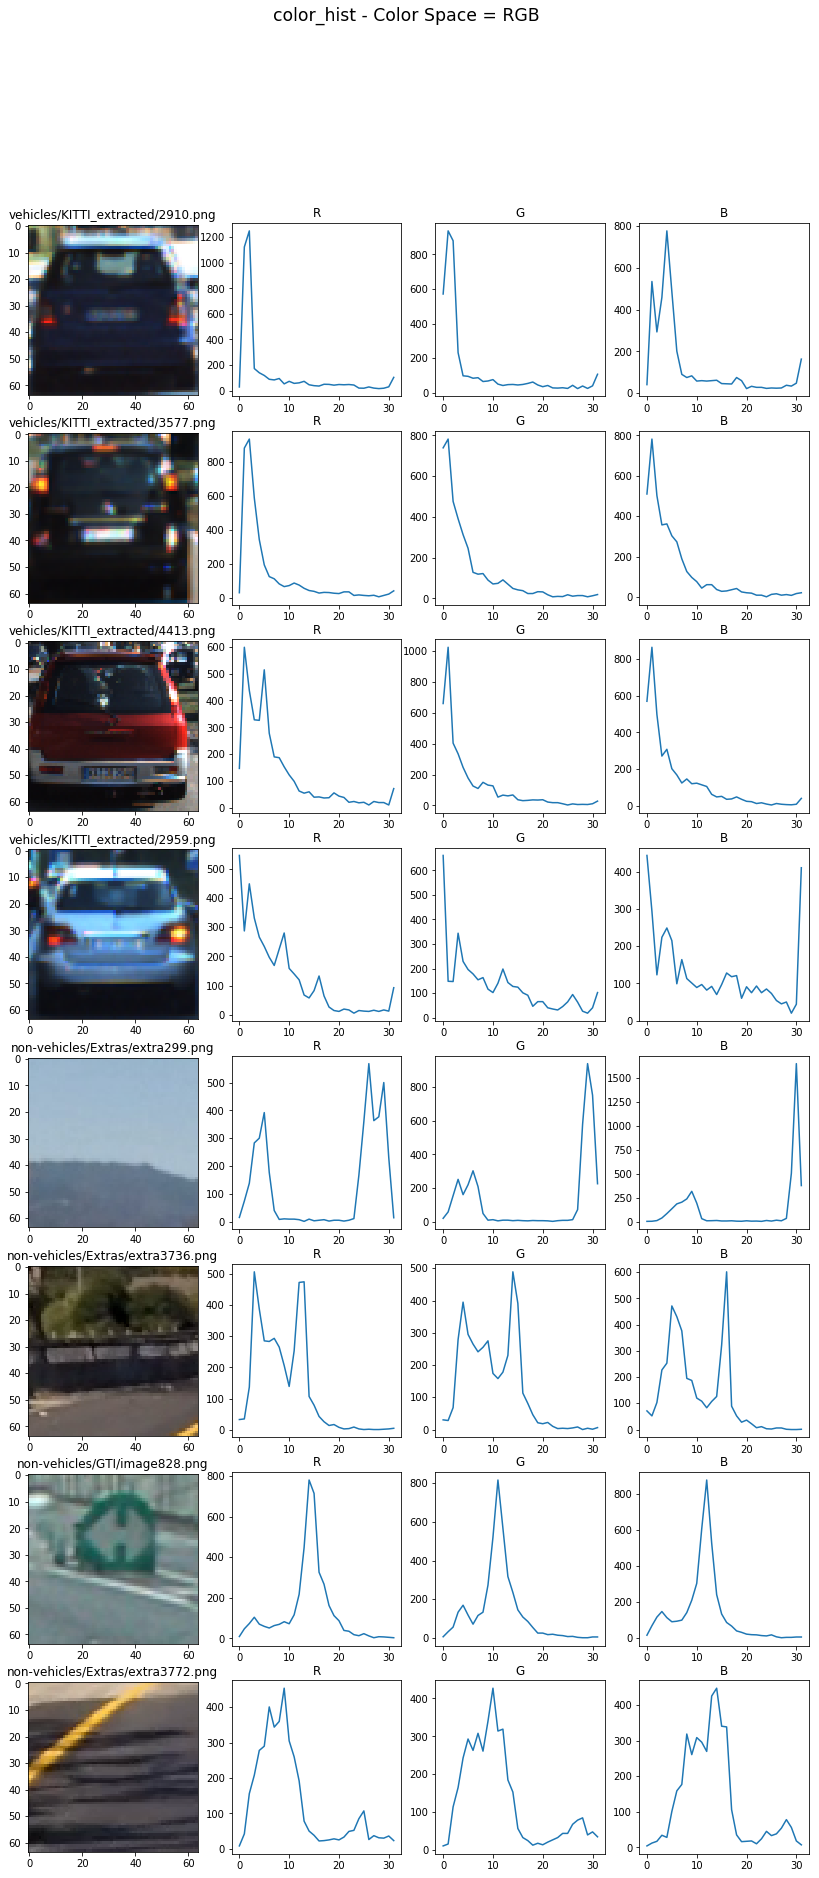

In [87]:
plot_colorhistogram(color=None, function='color_hist')

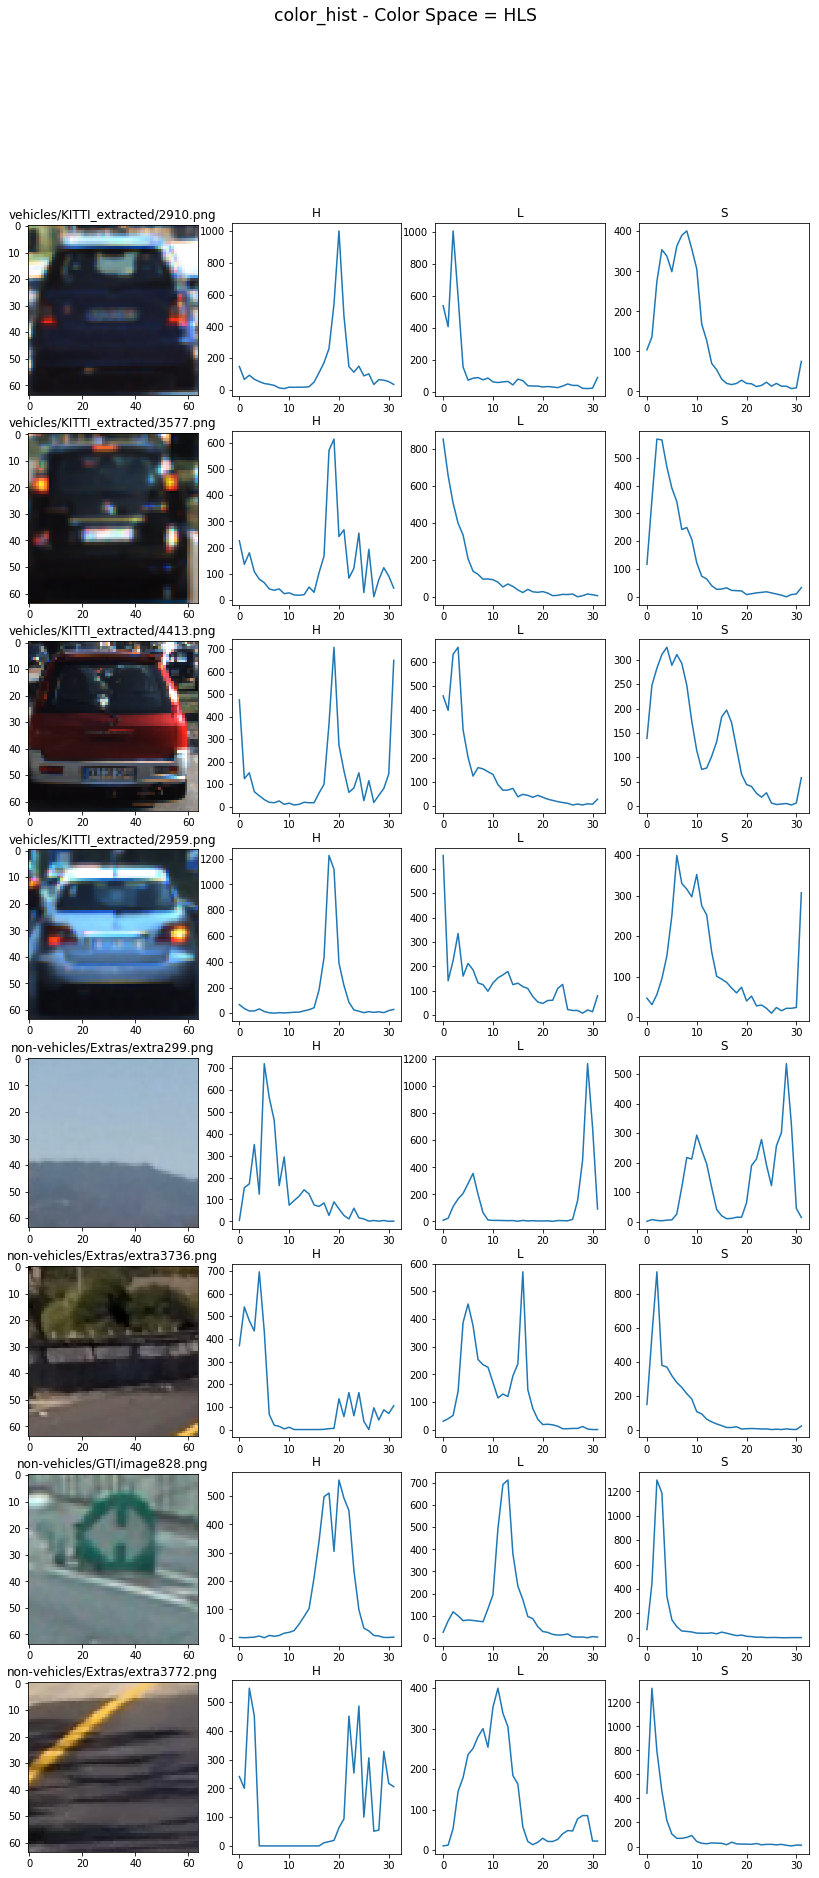

In [88]:
plot_colorhistogram(cv2.COLOR_RGB2HLS, 'H', 'L', 'S', function='color_hist')

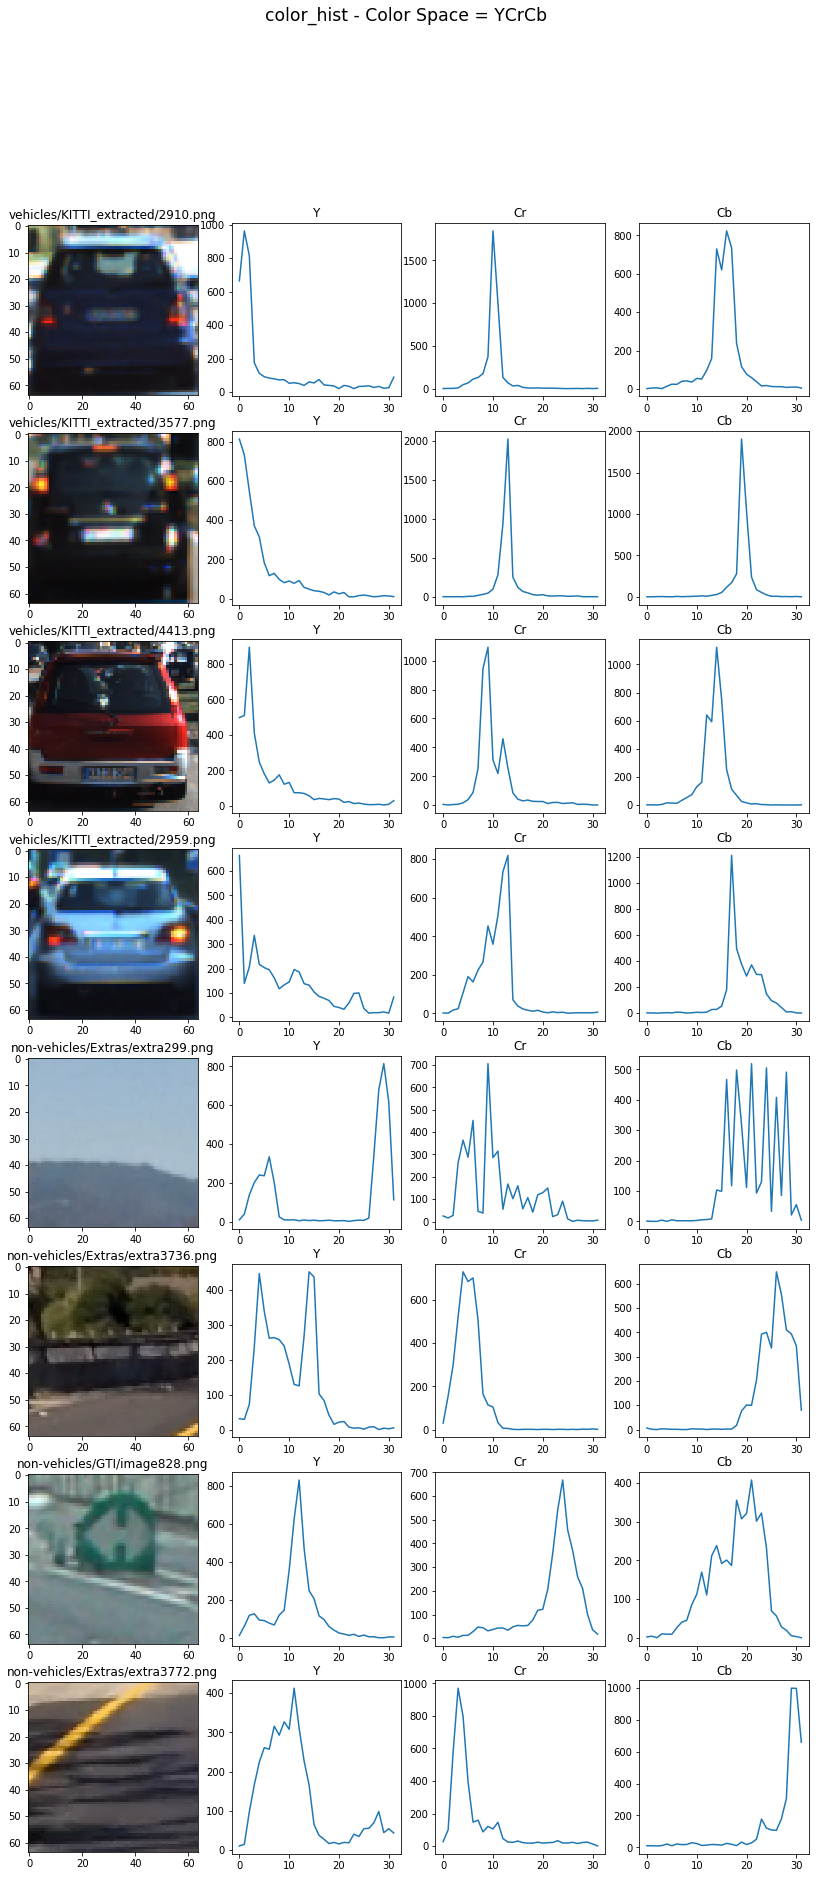

In [89]:
plot_colorhistogram(cv2.COLOR_RGB2YCrCb, 'Y', 'Cr', 'Cb', function='color_hist')

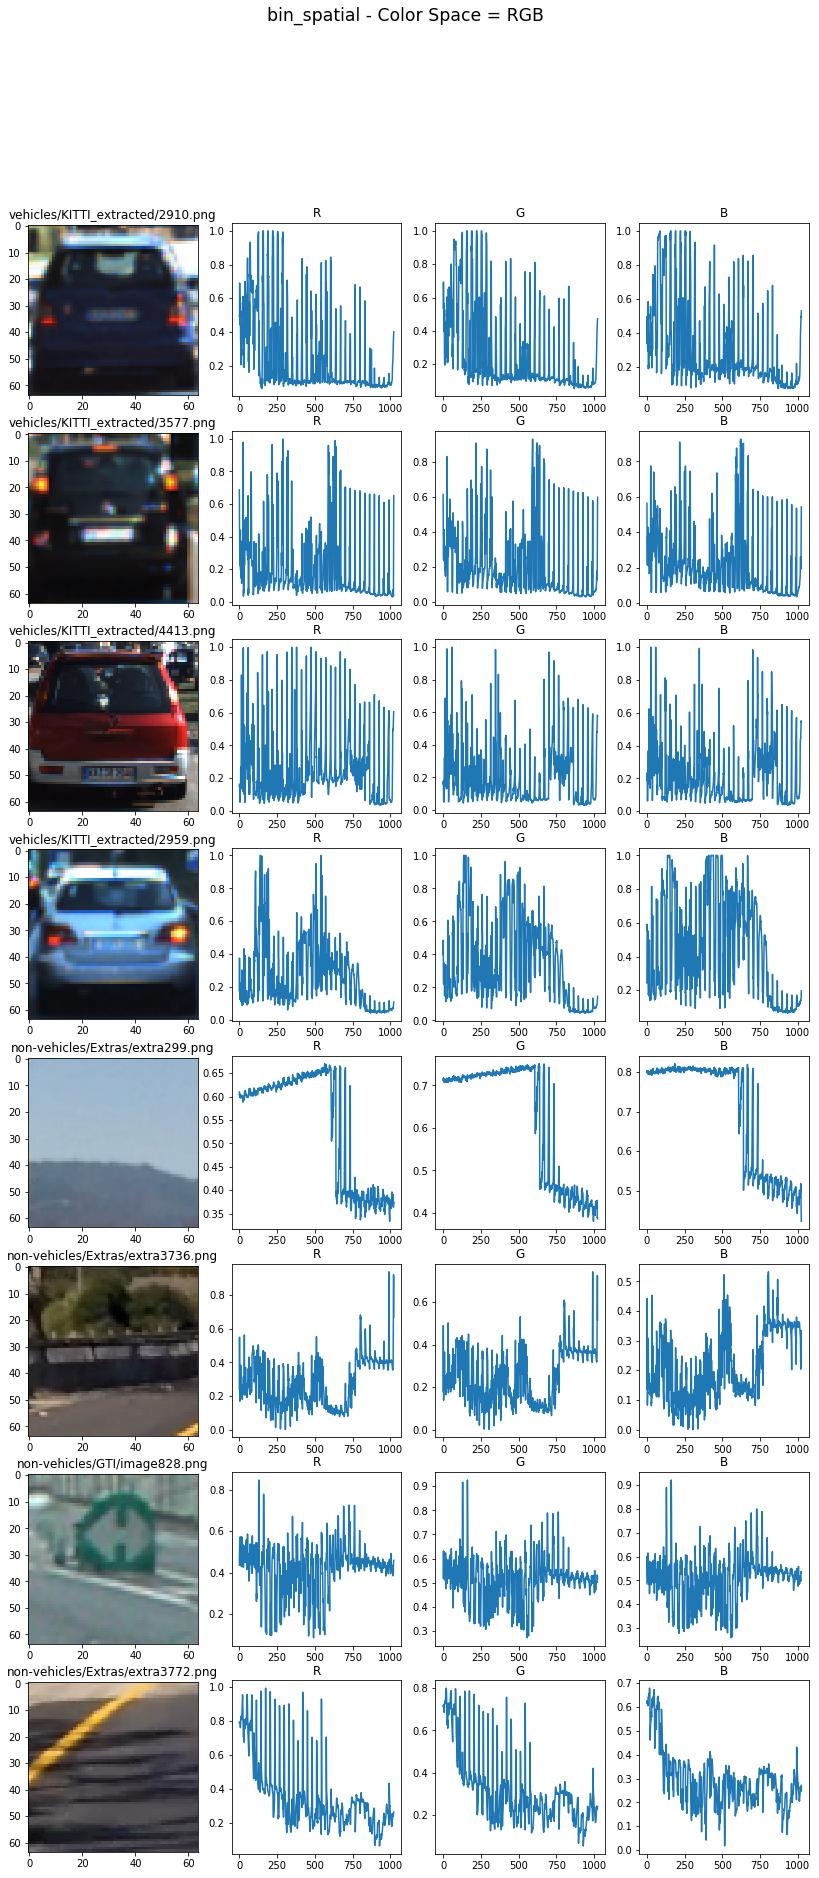

In [90]:
plot_colorhistogram(function='bin_spatial')

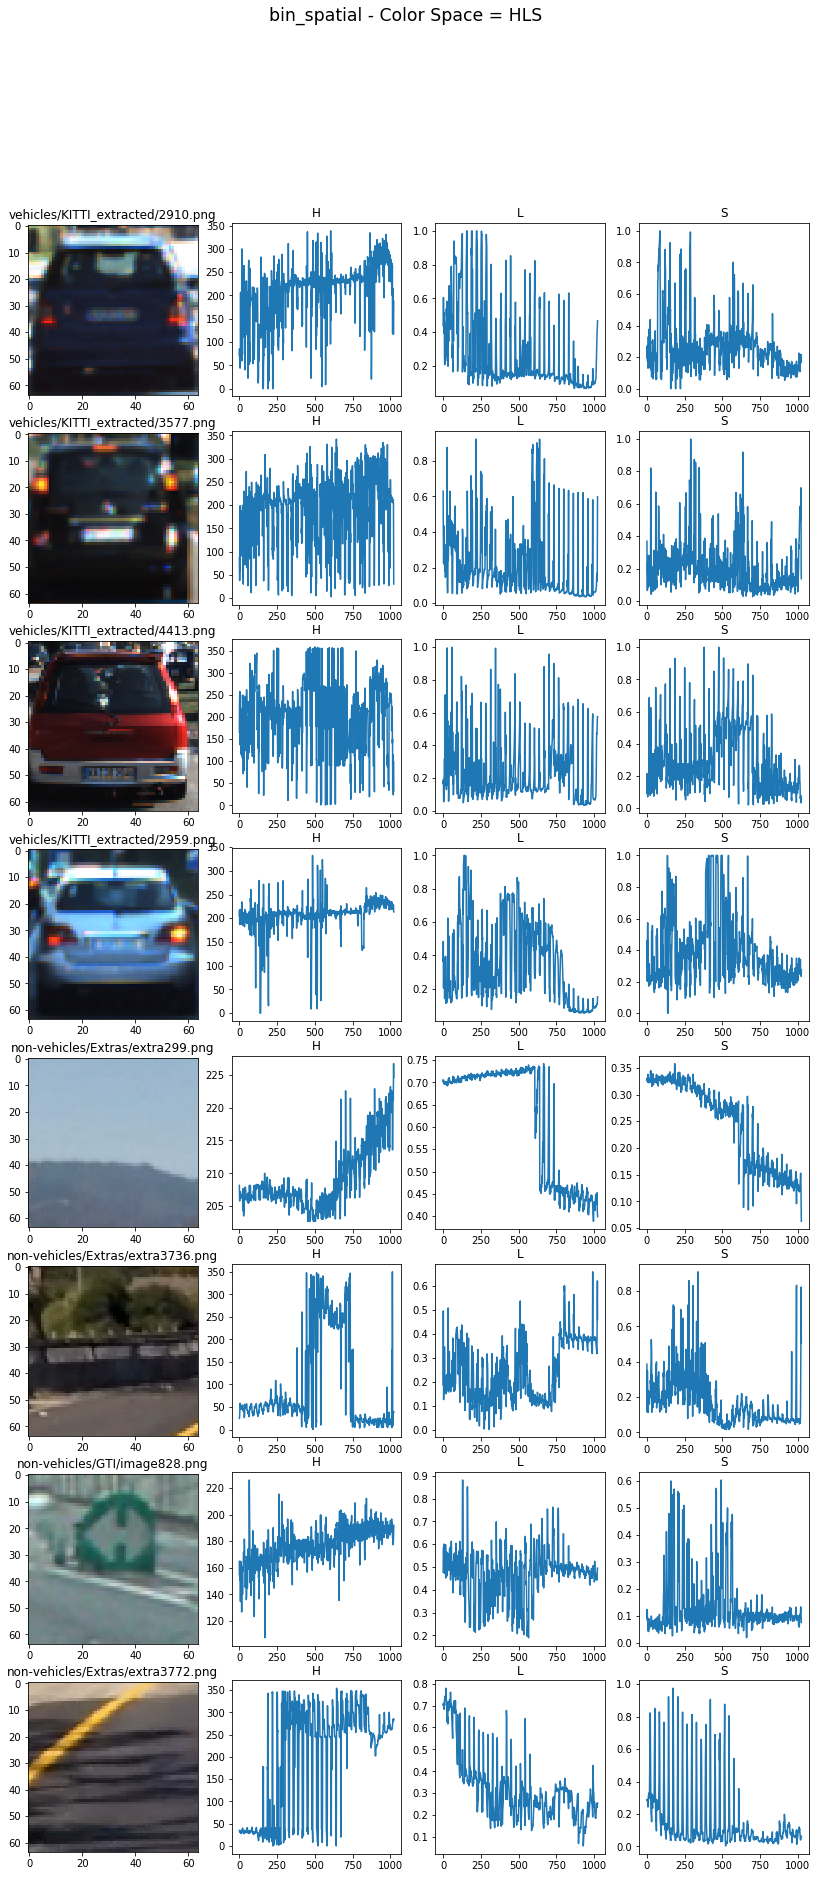

In [91]:
plot_colorhistogram(cv2.COLOR_RGB2HLS, 'H', 'L', 'S', function='bin_spatial')

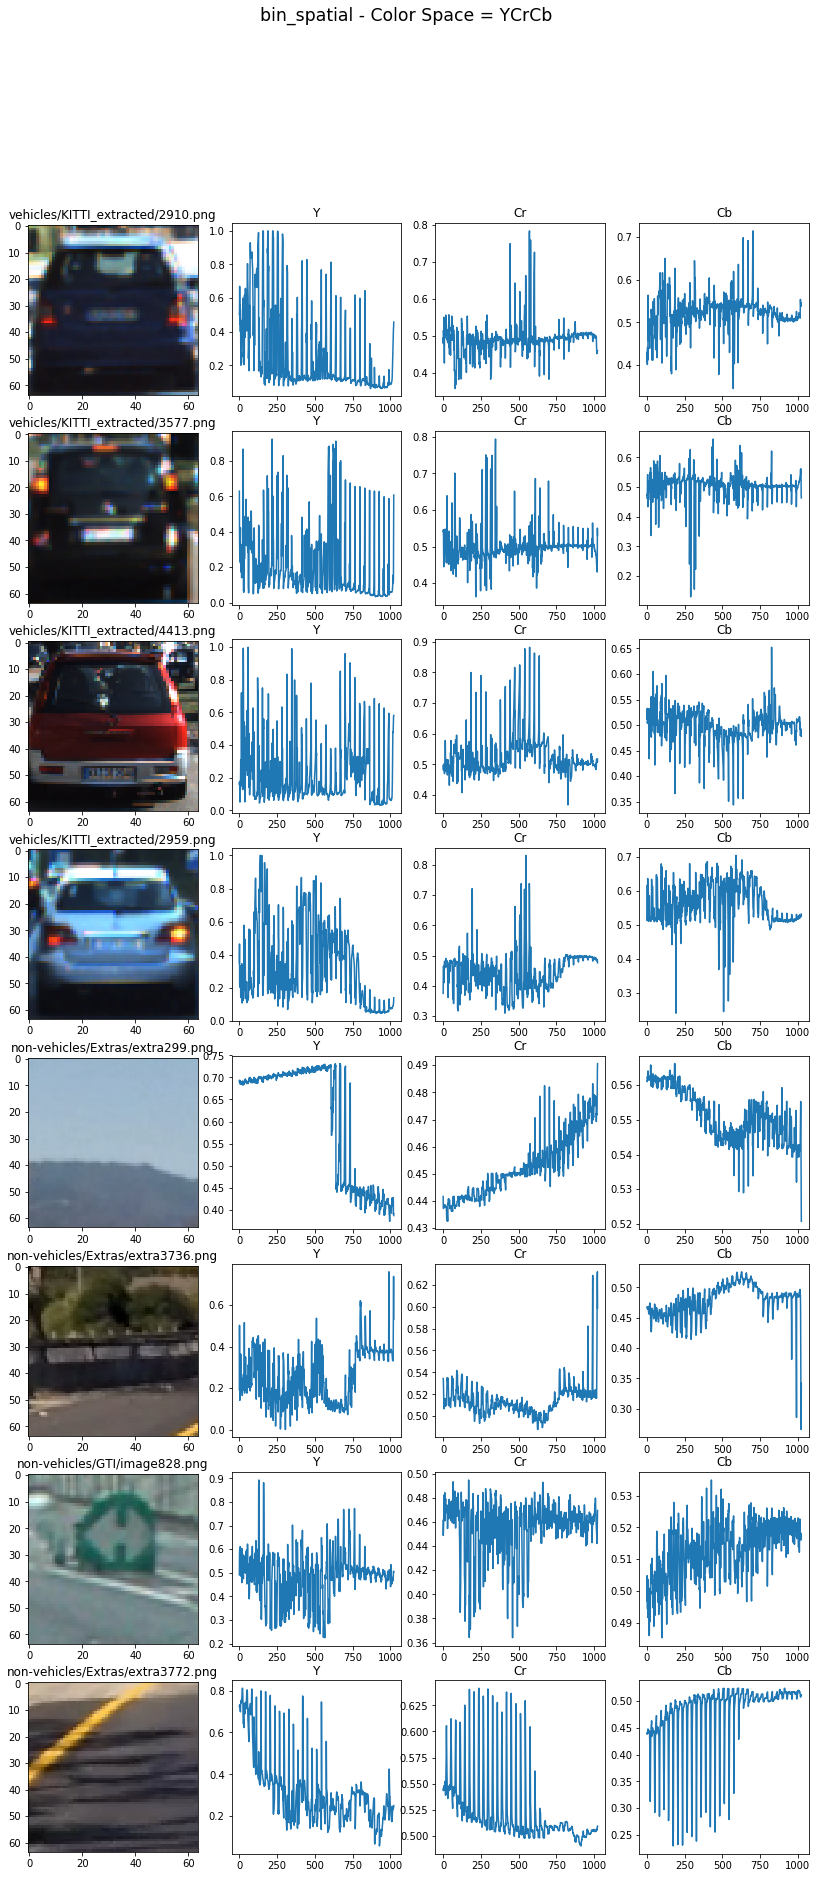

In [92]:
plot_colorhistogram(cv2.COLOR_RGB2YCrCb, 'Y', 'Cr', 'Cb', function='bin_spatial')

In [94]:

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [95]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

## SVM-Training

### SVM-Training - Read all car-filenames and noncar-filenames

### SVM-Training - Stack car and noncar, scaler, split in test_train

In [113]:
def feature_all(cspace, spatial_size, hist_bins, orient, pix_per_cell, cell_per_block, image_amout=5500):
    cars = []
    images = glob.glob(PATH_VEHICLE_IMAGES+'/*/*.png')
    for image in images:
        cars.append(image)
    
    cars = cars[:image_amout]
    
    notcars = []    
    images = glob.glob(PATH_NON_VEHICLE_IMAGES+'/*/*.png')
    for image in images:
        notcars.append(image)
        
    notcars = notcars[:image_amout]
    
    car_features = extract_features(cars, color_space=cspace, 
                            spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELLS, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True) 
    notcar_features = extract_features(notcars, color_space=cspace, 
                            spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELLS, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True) 
    
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.02, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    #svc = LinearSVC()
    
    #{'kernel': 'rbf', 'gamma': 0.0001, 'C': 10}
    svc = svm.SVC(C=10, kernel='rbf', gamma=0.0001)
    
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return X_train[:image_amout], X_test, y_train[:image_amout], y_test, X_scaler, svc

### SVM-Training - Use SVM to train

In [114]:
X_train, X_test, y_train, y_test, X_scaler, svc = feature_all('YCrCb', SPATIAL_BIN, HIST_BINS, ORIENT, PIX_PER_CELLS, CELL_PER_BLOCK)

Using: 6 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4488
88.93 Seconds to train SVC...
Test Accuracy of SVC =  1.0


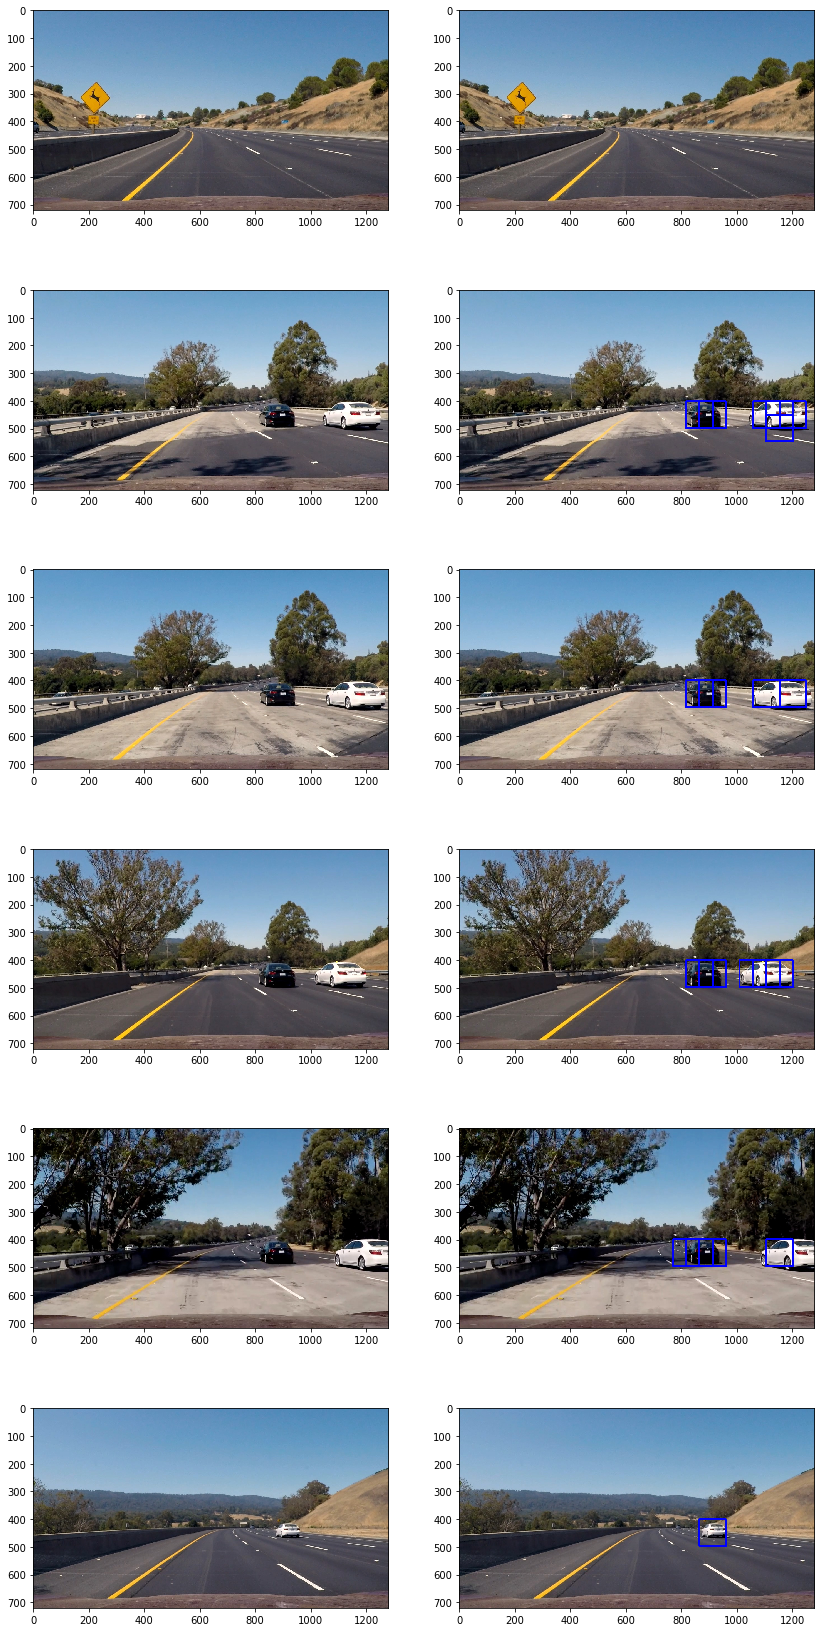

In [115]:
filenames = glob.glob('test_images/*.jpg')
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

f, ax = plt.subplots(len(filenames),2, figsize=(14,30))

for i, filename in enumerate(filenames):
    image = mpimg.imread(filename)
    ax[i][0].imshow(image)
       
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space='YCrCb', 
                            spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, 
                            orient=ORIENT, pix_per_cell=PIX_PER_CELLS, 
                            cell_per_block=CELL_PER_BLOCK, 
                            hog_channel='ALL', spatial_feat=True, 
                            hist_feat=True, hog_feat=True)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    ax[i][1].imshow(window_img)

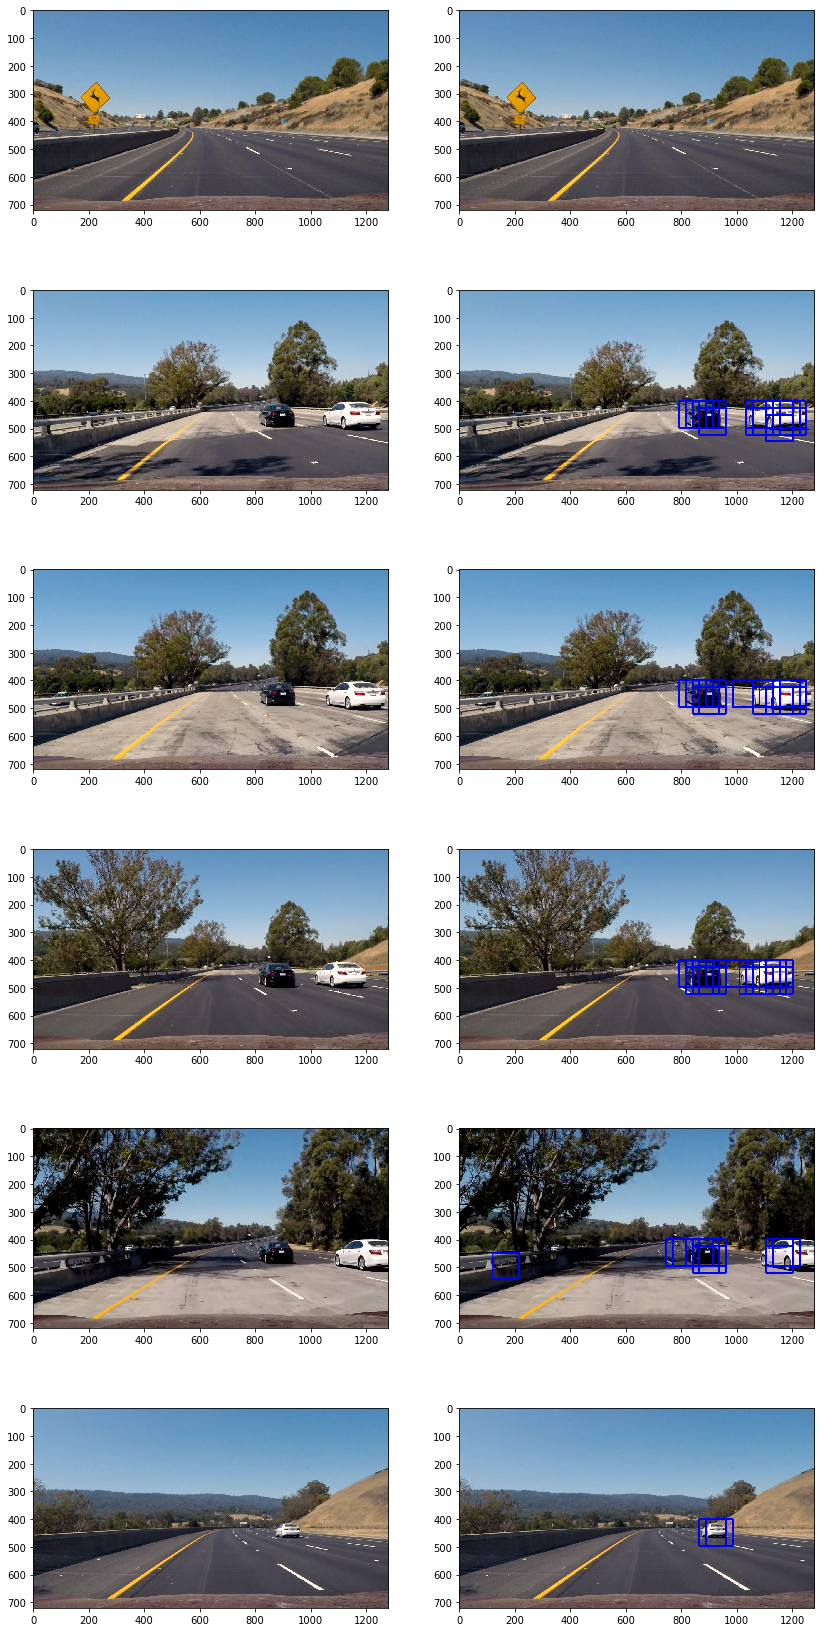

In [129]:
filenames = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(len(filenames),2, figsize=(14,30))

hot_windows = []
for i, filename in enumerate(filenames):
    image = mpimg.imread(filename)
    ax[i][0].imshow(image)
    
    image_classified, hot_windows = find_cars(img=image,ystart=YSTART,ystop=YSTOP, scale=SCALE, svc=svc, X_scaler=X_scaler, orient=ORIENT, 
                      pix_per_cell=PIX_PER_CELLS,cell_per_block=CELL_PER_BLOCK, spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, hot_windows=hot_windows)
    ax[i][1].imshow(image_classified)

## Heatmap

((864, 400), (960, 496))

In [117]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

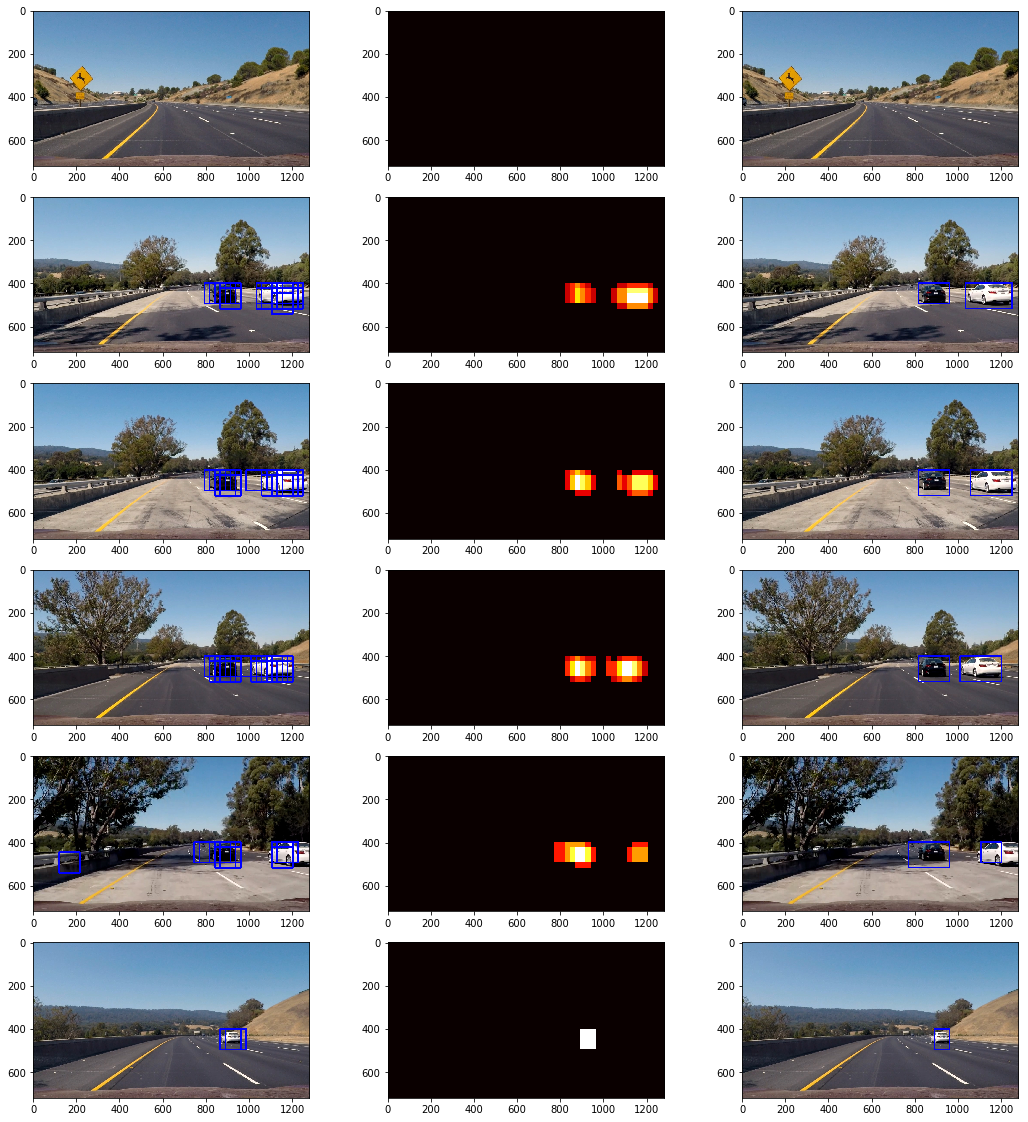

In [140]:
filenames = glob.glob('test_images/*.jpg')

f, ax = plt.subplots(len(filenames),3, figsize=(18,20))
#hot_windows = []
for i, filename in enumerate(filenames):
    hot_windows = []
    image = mpimg.imread(filename)
    #ax[i][0].imshow(image)
    image_classified, hot_windows = find_cars(img=image,ystart=YSTART,ystop=YSTOP, scale=SCALE, svc=svc, X_scaler=X_scaler, orient=ORIENT, 
                      pix_per_cell=PIX_PER_CELLS,cell_per_block=CELL_PER_BLOCK, spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, hot_windows=hot_windows)
    ax[i][0].imshow(image_classified)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    ax[i][1].imshow(heatmap, cmap='hot')
    ax[i][2].imshow(draw_img)
    
    heatmap = 0

## Video Implementation

In [145]:
def find_vehicles_in_video(image):
    hot_windows = []

    image_classified, hot_windows = find_cars(img=image,ystart=YSTART,ystop=YSTOP, scale=SCALE, svc=svc, X_scaler=X_scaler, orient=ORIENT, 
                      pix_per_cell=PIX_PER_CELLS,cell_per_block=CELL_PER_BLOCK, spatial_size=(SPATIAL_BIN, SPATIAL_BIN), hist_bins=HIST_BINS, hot_windows=hot_windows)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img    

In [146]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [147]:
output0 = 'output_test_video.mp4'
clip0 = VideoFileClip("test_video.mp4")
output_clip0 = clip0.fl_image(find_vehicles_in_video) #NOTE: this function expects color images!!
%time output_clip0.write_videofile(output0, audio=False)

[MoviePy] >>>> Building video output_test_video.mp4
[MoviePy] Writing video output_test_video.mp4


 97%|█████████▋| 38/39 [01:55<00:02,  2.85s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video.mp4 

CPU times: user 1min 56s, sys: 64 ms, total: 1min 56s
Wall time: 1min 57s


In [148]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output0))

In [149]:
output1 = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip1 = clip1.fl_image(find_vehicles_in_video) #NOTE: this function expects color images!!
%time output_clip1.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [1:01:10<00:02,  2.88s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 1h 1min 21s, sys: 3.42 s, total: 1h 1min 24s
Wall time: 1h 1min 12s


In [150]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))